In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf

import main_dm_baryon_scattering as main

from tqdm import tqdm_notebook as tqdm

import pickle

In [4]:
%autoreload
import config
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

f_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def xsec_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]

In [5]:
struct_boost = phys.struct_boost_func(model='einasto_subs')
struct_boost_NFW = phys.struct_boost_func(model='NFW_no_subs')
struct_boost_pwave = phys.struct_boost_func(model='pwave_NFW_no_subs')

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


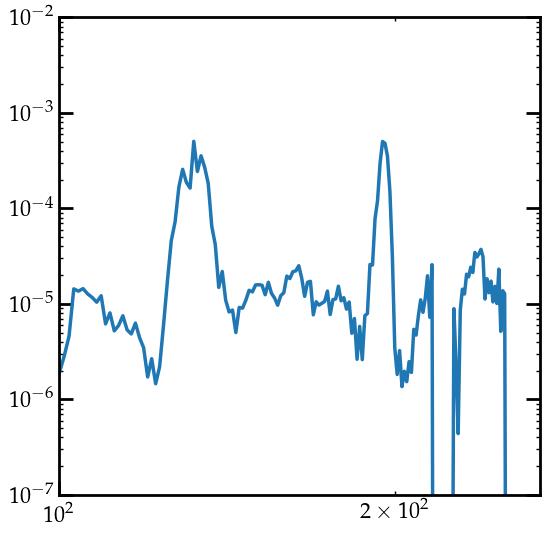

In [6]:
import csv
ys = []
with open('/Users/gregoryridgway/Desktop/DM/NSDM/final_y_r-process') as csvfile:
    reader = csv.reader(csvfile)
    for i, row in enumerate(reader):
        strs = row[0].split(' ')
#         print(strs)
        nums = strs[-1].split('E')
        if i<10:
            ys.append([float(strs[5]),float(nums[0])*10**float(nums[1])])
        elif i<100:
            ys.append([float(strs[4]),float(nums[0])*10**float(nums[1])])
        else:
            ys.append([float(strs[3]),float(nums[0])*10**float(nums[1])])
ys = np.array(ys)

plt.figure()
plt.axis([100, 270, 1e-7, 1e-2])
plt.loglog()
plt.plot(ys[:,0], ys[:,1])

# Improved f_exc

In [6]:
mDM=1e6
lifetime=3e25
sigmav=3e-26
datums = main.evolve(
    DM_process='decay', mDM=mDM, primary='phot_delta',
    start_rs = 3000, sigmav=sigmav, lifetime=lifetime,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.01
)
eleceng = datums['lowengelec'].eng

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [8]:
import darkhistory.low_energy.lowE_electrons as lowE_elec
import darkhistory.low_energy.lowE_photons as lowE_phot
import darkhistory.low_energy.lowE_deposition as lowE
MEDEA_interp = lowE_elec.make_interpolator()

In [9]:
rs_list = datums['rs']
eleceng = datums['lowengelec'].eng
# elec_exc = [lowE_elec.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['x'][i,0], 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e8, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]))[2]
#  for i in np.arange(len(rs_list))]

phot_exc = [lowE_phot.compute_fs( 
           datums['lowengphot'][i],
           np.array([
                1. - phys.xHII_std(rs_list[i]),
                phys.chi - phys.xHeII_std(rs_list[i]),
                phys.xHeII_std(rs_list[i])
            ]), 
           phys.inj_rate('decay', rs_list[i], mDM=mDM, sigmav=sigmav, lifetime=lifetime), 
           4*.001/phys.hubble(rs_list[i]), method='old')[2]
 for i in np.arange(len(rs_list))]

# tot_exc = [lowE.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['lowengphot'][i], 
#            np.array([
#                 1. - phys.xHII_std(rs_list[i]),
#                 phys.chi - phys.xHeII_std(rs_list[i]),
#                 phys.xHeII_std(rs_list[i])
#             ]), 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e9, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]), 
#            [0,0,0,0,0], cmbloss=0, 
#            method='no_He', 
#            separate_higheng=True, 
#            cross_check=False)[0][2]
# for i in np.arange(len(rs_list))]

# tot_exc = [lowE.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['x'][i,0], 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e8, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]))[2]
#  for i in np.arange(len(rs_list))]

In [10]:
fexc = datums['f']['low']['exc']+0*datums['f']['high']['exc']
rs_list = datums['lowengphot'].rs
nrms = phys.nB * rs_list**3 / (4*.001/phys.hubble(rs_list)) /(
    phys.inj_rate('decay', rs_list, mDM=mDM, sigmav=sigmav, lifetime=lifetime)
)
fexc2 = datums['lowengphot'].toteng(bound_type='eng',
                            bound_arr=np.array([phys.lya_eng,phys.rydberg])
                           )*nrms

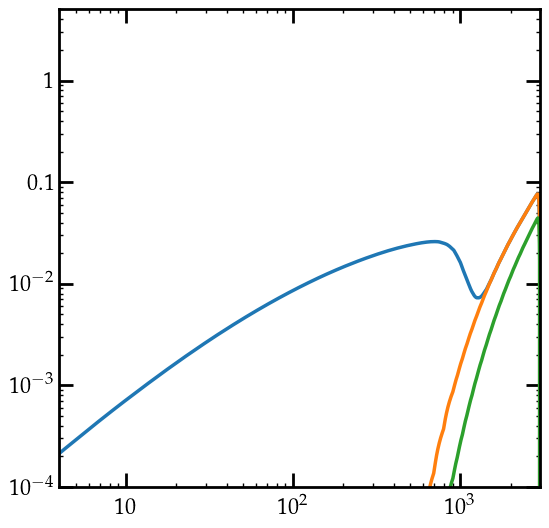

In [11]:
plt.figure()
ax = plt.gca()
plt.axis([4,3e3,1e-4,5])
ax.loglog()
plt.plot(rs_list,fexc)
plt.plot(rs_list,fexc2[0])
# plt.plot(rs_list,phys.f_std(1e9,rs_list,'phot','pwave',True,'exc'))
# plt.plot(rs_list,fexc2[0]+elec_exc)
# plt.plot(rs_list,tot_exc)
plt.plot(rs_list,phot_exc)

# Improved lowengelec

# Ionization: Total

In [12]:
import csv
HI_ionization_data = []
with open('/Users/gregoryridgway/Desktop/Reionization_Rates/HI_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HI_ionization_data.append([float(row[0]),float(row[1])])
HI_ionization_data = np.array(HI_ionization_data)

HeI_ionization_data = []
with open('/Users/gregoryridgway/Desktop/Reionization_Rates/HeI_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HeI_ionization_data.append([float(row[0]),float(row[1])])
HeI_ionization_data = np.array(HeI_ionization_data)

HeII_ionization_data = []
with open('/Users/gregoryridgway/Desktop/Reionization_Rates/HeII_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HeII_ionization_data.append([float(row[0]),float(row[1])])
HeII_ionization_data = np.array(HeII_ionization_data)

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


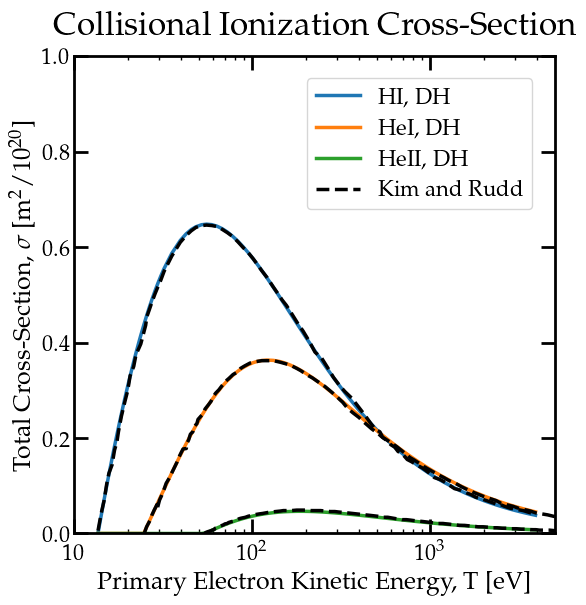

In [13]:
%autoreload
plt.figure()
plt.xscale('log')
plt.axis([10,5e3,0,1])
eleceng = HI_ionization_data[:,0]

plt_HI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HI', method='MEDEA')*1e16, label = r'HI, DH')

plt_HeI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeI', method='MEDEA')*1e16, label = r'HeI, DH')
plt_HeII, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeII', method='MEDEA')*1e16, label = r'HeII, DH')

plt_KimHI, = plt.plot(HI_ionization_data[:,0],HI_ionization_data[:,1], linestyle='--', color='k', label=r'Kim and Rudd')
plt_KimHeI, = plt.plot(HeI_ionization_data[:,0],HeI_ionization_data[:,1], linestyle='--', color='k', label=r'HeI, Kim and Rudd')
plt_KimHeII, = plt.plot(HeII_ionization_data[:,0],HeII_ionization_data[:,1], linestyle='--', color='k', label=r'HeII, Kim and Rudd')



plt.title(r'Collisional Ionization Cross-Section')
plt.xlabel(r'Primary Electron Kinetic Energy, T [eV]')
plt.ylabel(r'Total Cross-Section, $\sigma$ [m$^2/10^{20}$]')

plt.legend(handles = [plt_HI, plt_HeI, plt_HeII, plt_KimHI])

# Ionization: Differential

In [14]:
tmpelec = 10**np.arange(-5,3,.02)

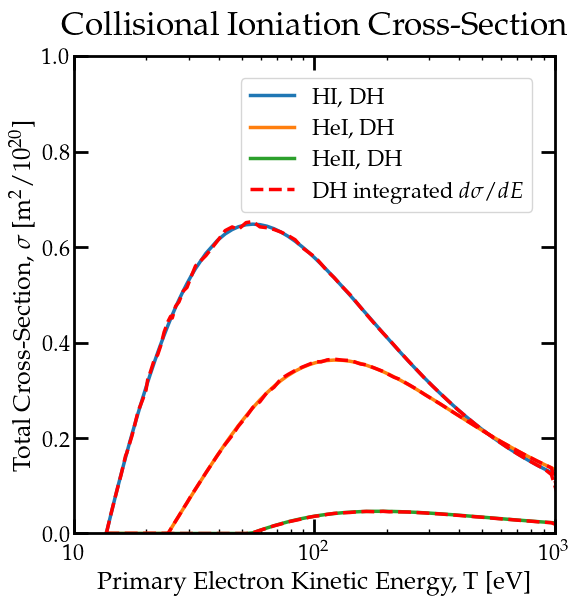

In [15]:
%autoreload
plt.figure()
plt.xscale('log')
plt.axis([10,1e3,0,1])
eleceng = HI_ionization_data[:,0]

plt_HI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HI', method='MEDEA')*1e16, label = r'HI, DH')

plt_HeI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeI', method='MEDEA')*1e16, label = r'HeI, DH')

plt_HeII, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeII', method='MEDEA')*1e16, label = r'HeII, DH')


tmpdataH = np.array([
    sum(phys.coll_ion_sec_elec_spec(el, tmpelec, species='HI', method='MEDEA'))*1e16/2
    for el in eleceng
])

plt_HI_diff, = plt.plot(
    eleceng, tmpdataH, color='red', linestyle='--', label = r'DH integrated $d\sigma/dE$'
)

tmpdataHe = np.array([
    sum(phys.coll_ion_sec_elec_spec(el, tmpelec, species='HeI', method='MEDEA'))*1e16/2
    for el in eleceng
])

plt_HeI_diff, = plt.plot(
    eleceng, tmpdataHe, color='red', linestyle='--'
)

tmpdata = np.array([
    sum(phys.coll_ion_sec_elec_spec(el, tmpelec, species='HeII', method='MEDEA'))*1e16/2
    for el in eleceng
])

plt_HeII_diff, = plt.plot(
    eleceng, tmpdata, color='red', linestyle='--'
)


plt.title(r'Collisional Ioniation Cross-Section')
plt.xlabel(r'Primary Electron Kinetic Energy, T [eV]')
plt.ylabel(r'Total Cross-Section, $\sigma$ [m$^2/10^{20}$]')

plt.legend(handles = [plt_HI, plt_HeI, plt_HeII, plt_HI_diff])

# Excitation

In [17]:
H_exc_data=np.resize(
    np.loadtxt('/Users/gregoryridgway/Desktop/Hydrogen_excitation_np.txt'),
    (10,58))

H_exc_data = np.transpose(np.append(np.array([np.zeros(10)]),np.transpose(H_exc_data),axis=0))
H_exc_data[0,0] = phys.lya_eng

OSError: /Users/gregoryridgway/Desktop/Hydrogen_excitation_np.txt not found.

In [18]:
H_exc_data2 = {
    'eng_p': H_exc_data[0],
    '2p': H_exc_data[1],
    '3p': H_exc_data[2],
    '4p': H_exc_data[3],
    '5p': H_exc_data[4],
    '6p': H_exc_data[5],
    '7p': H_exc_data[6],
    '8p': H_exc_data[7],
    '9p': H_exc_data[8],
    '10p': H_exc_data[9],
    'eng_s': np.array([phys.lya_eng, 25,30.6,54,100,136,200,300,400,680]),
    '2s': np.array(
        [0, 0.076, 0.057, 0.042, 0.036, 0.031, 0.024, 0.018, 0.0135, 0.0085]
    )*np.pi*phys.bohr_rad**2*1e16
}

NameError: name 'H_exc_data' is not defined

In [49]:
#pickle.dump(H_exc_data2,open('/Users/gregoryridgway/Downloads/dataverse_files_06_08_2019/H_exc_xsec_data.p','wb'))

In [ ]:
He_exc_data=np.resize(
    np.loadtxt('/Users/gregoryridgway/Desktop/He_excitation_np.txt'),
    (10,43))

He_exc_data = np.transpose(np.append(np.array([np.zeros(10)]),np.transpose(He_exc_data),axis=0))
He_exc_data[0,0] = phys.He_exc_eng['21p']

In [ ]:
He_exc_data2 = {
    'eng_p': He_exc_data[0],
    '2p': He_exc_data[1],
    '3p': He_exc_data[2],
    '4p': He_exc_data[3],
    '5p': He_exc_data[4],
    '6p': He_exc_data[5],
    '7p': He_exc_data[6],
    '8p': He_exc_data[7],
    '9p': He_exc_data[8],
    '10p': He_exc_data[9],
    'eng_s': None,
    '2s': None
}

In [34]:
#pickle.dump(He_exc_data2,open('/Users/gregoryridgway/Downloads/dataverse_files_06_08_2019/He_exc_xsec_data.p','wb'))

In [ ]:
import csv
Kim_exc_data = []
with open('/Users/gregoryridgway/Desktop/exc_2p.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        Kim_exc_data.append([float(row[0]),float(row[1])])
Kim_exc_data = np.array(Kim_exc_data)

In [7]:
%autoreload
import config

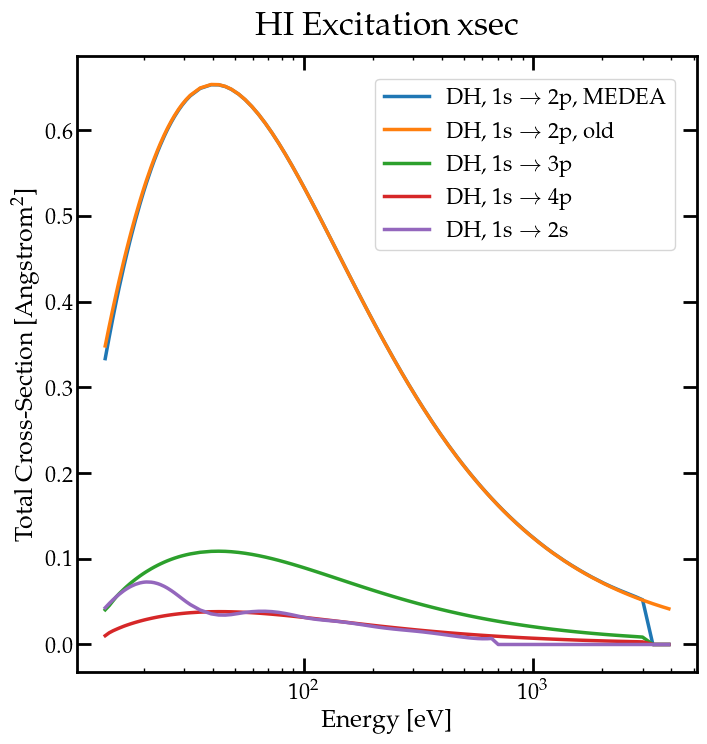

In [19]:
%autoreload
plt.figure(figsize=(8,8))
plt.xscale('log')
# plt.axis([10,3000,0,.1])
plt.title(r'HI Excitation xsec')
plt.xlabel(r'Energy [eV]')
plt.ylabel(r'Total Cross-Section [Angstrom$^2$]')
# plt.axis([10,1e5,0,.8])
# eng = Kim_exc_data[:,0]
eng = eleceng
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'MEDEA',state='2p')*1e16,label=r'DH, 1s $\to$ 2p, MEDEA')
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'old')*1e16,label=r'DH, 1s $\to$ 2p, old')
# plt.plot(eng,Kim_exc_data[:,1],linestyle='--',color='k', label=r'Kim and Rudd')
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'MEDEA',state='3p')*1e16,label=r'DH, 1s $\to$ 3p')
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'MEDEA',state='4p')*1e16,label=r'DH, 1s $\to$ 4p')
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'MEDEA',state='2s')*1e16,label=r'DH, 1s $\to$ 2s')

plt.legend()

# Distortions

In [ ]:
import main

In [18]:
mDM=5e3
lifetime = 3e25
sigmav = xsec_bound_phot_CMB(mDM,'swave')
species = 'phot'
DM_process = 'swave'

eng = tmp5e3['lowengphot'][0].eng
rs_list = tmp5e3['lowengphot'].rs

In [74]:
mDM=5e3
Einj=2*mDM
sigmav = xsec_bound_phot_CMB(mDM,'swave')
DM_process='swave'


tmp5e3 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data5e3.p','rb'))
photdep_list = tmp5e3['lowengphot'].toteng(bound_type='eng', bound_arr=(0,phys.lya_eng))/(
phys.inj_rate(DM_process, rs_list, mDM=mDM, sigmav=sigmav)  * 
    4*.001/phys.hubble(rs_list)/phys.nB/rs_list**3)[0]

In [75]:
photdep_list[0].shape

(1655,)

In [77]:
photdep_list[0]

array([ 0.00000000e+00, -6.40992200e-01, -4.30210122e-02, ...,
        1.58914999e-05,  1.58284863e-05,  1.57648496e-05])

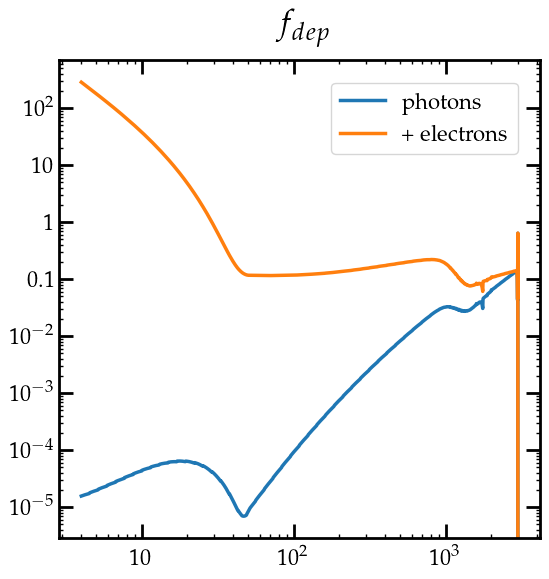

In [76]:
plt.figure()
plt.loglog()

fulldep_list=tmp5e3['f']['low']['cont'] + tmp5e3['f']['high']['cont']

plt.title(r'$f_{cont}$')
plt.plot(rs_list,np.abs(photdep_list[0]), label = 'photons')
plt.plot(rs_list,np.abs(fulldep_list), label = '+ electrons')
plt.legend()

In [53]:
phys.He_exc_eng['21s']-phys.He_exc_eng['23s']

0.7961602827811056

In [54]:
13179.0*phys.kB

1.135678236996

In [102]:
%autoreload
mDM=5e3
lifetime = 3e25
sigmav = xsec_bound_phot_CMB(mDM,'swave')
species = 'phot'
DM_process = 'swave'

data5e3 = main.evolve(
    DM_process=DM_process, mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
    primary=species+'_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost,
    end_rs=4.004
)

In [116]:
pickle.dump(data5e3,open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data5e3.p','wb'))

In [10]:
tmp5e3 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data5e3.p','rb'))
tmp6e5 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data6e5.p','rb'))
tmp1e8 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data1e8.p','rb'))
tmp3e10 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data3e10.p','rb'))
tmp6e12 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data6e12.p','rb'))

lowengphot = tmp5e3['lowengphot']
eng = lowengphot.eng
rs_list = lowengphot.rs

In [50]:
def norm_fac(rs,mDM):
    # Normalization to convert from per injection event to 
    # per baryon per dlnz step.
    if DM_process == 'decay':
        Einj = mDM
    else:
        Einj = 2*mDM
    return (phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=lifetime, sigmav=xsec_bound_phot_CMB(mDM,'swave')) / Einj) * (
        .001 * 4 / phys.hubble(rs) / (phys.nB * rs**3)
    )

In [11]:
def get_distortion(spec, mDM):
#     if DM_process == 'decay':
#         Einj = mDM/2
#     else:
#         Einj = mDM
        
#     rate_func_N = phys.inj_rate(
#         DM_process, 
#         rs_list, 
#         mDM=mDM, 
#         lifetime=lifetime, 
#         sigmav=xsec_bound_phot_CMB(mDM,'swave')
#     ) / Einj
    
    #spec = spec/norm_fac(rs_list, mDM) * rate_func_N * .001 * 4 / phys.hubble(rs_list)
#     spec = spec * phys.nB * rs_list**3
    spec.redshift(np.ones_like(rs_list))
    return spec.sum_specs()*phys.nB

In [12]:
distortion_spec_5e3 = get_distortion(tmp5e3['lowengphot'], 5e3)
distortion_spec_6e5 = get_distortion(tmp6e5['lowengphot'], 6.19e5)
distortion_spec_1e8 = get_distortion(tmp1e8['lowengphot'], 1.31e8)
distortion_spec_3e10 = get_distortion(tmp3e10['lowengphot'], 2.77e10)
distortion_spec_6e12 = get_distortion(tmp6e12['lowengphot'], 5.85e12)

In [28]:
lowengphot = lowengphot/norm_fac(rs_list, mDM)
lowengphot.redshift(np.ones_like(rs_list))
distortion_spec = lowengphot.sum_specs()
distortion_spec.switch_spec_type()

In [31]:
# 1e7 ergs/s = 1 J/s
# 1e4 cm^2 = 1 m^2
phys.c * phys.hbar * 2*np.pi * eng*distortion_spec_5e3.dNdE / (4*np.pi) * 1e-7 * 1e4

array([-2.35323642e-18, -2.73289513e-18, -3.17092233e-18, -3.67523469e-18,
       -4.25446370e-18, -4.91774092e-18, -5.67456073e-18, -6.53460222e-18,
       -7.50708761e-18, -8.60003586e-18, -9.81964444e-18, -1.11689234e-17,
       -1.26456434e-17, -1.42407073e-17, -1.59357346e-17, -1.76990671e-17,
       -1.94824703e-17, -2.12185524e-17, -2.28182230e-17, -2.41629492e-17,
       -2.51095989e-17, -2.54853427e-17, -2.51047558e-17, -2.37745386e-17,
       -2.13128729e-17, -1.75765037e-17, -1.24931519e-17, -6.09657173e-18,
        1.44129843e-18,  9.79133281e-18,  1.84662119e-17,  2.68520027e-17,
        3.42651345e-17,  4.00480607e-17,  4.36703098e-17,  4.48208519e-17,
        4.34824075e-17,  3.99464339e-17,  3.47567291e-17,  2.86174394e-17,
        2.22637640e-17,  1.63312272e-17,  1.12653730e-17,  7.28596772e-18,
        4.40350643e-18,  2.47762014e-18,  1.30460735e-18,  6.49397671e-19,
        2.92250944e-19,  1.18857799e-19,  4.36573919e-20,  1.44470948e-20,
        4.29123793e-21,  

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


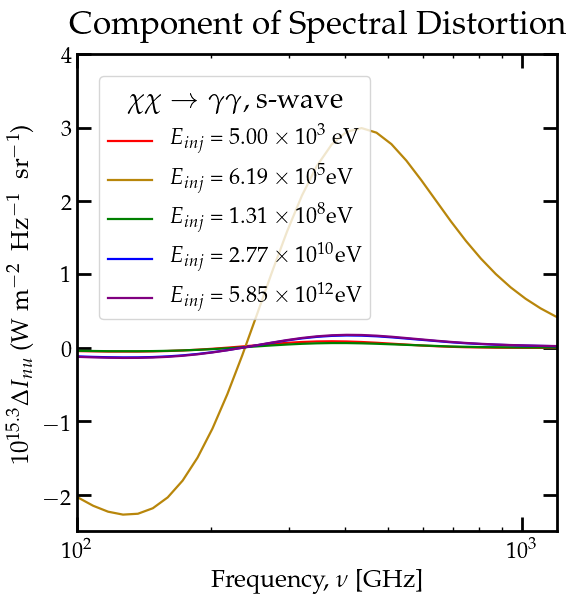

In [13]:
plt.figure()
ax = plt.gca()
# ax.loglog()
plt.xscale('log')
linewidth=1.6
eng = distortion_spec_5e3.eng/phys.hbar/(2*np.pi)/1e9
norm=2e15

fac=1e-7*1e4 * norm * phys.c * phys.hbar * 2*np.pi / (4*np.pi) *(phys.hbar*(2*np.pi)*1e9)

plt.plot(
    eng, 
    fac * eng*distortion_spec_5e3.dNdE ,
    linewidth=linewidth,
    color='red',
    label = r'$E_{inj}$ = $5.00 \times 10^3$ eV'
)

plt.plot(
    eng, 
    fac * eng*distortion_spec_6e5.dNdE,
    linewidth=linewidth,
    color='darkgoldenrod',
    label = r'$E_{inj}$ = $6.19 \times 10^5$eV'
)

plt.plot(
    eng, 
    fac * eng*distortion_spec_1e8.dNdE,
    linewidth=linewidth,
    color='green',
    label = r'$E_{inj}$ = $1.31 \times 10^8$eV'
)

plt.plot(
    eng, 
    fac * eng*distortion_spec_3e10.dNdE,
    linewidth=linewidth,
    color='blue',
    label = r'$E_{inj}$ = $2.77 \times 10^{10}$eV'
)

plt.plot(
    eng, 
    fac * eng*distortion_spec_6e12.dNdE,
    linewidth=linewidth,
    color='purple',
    label = r'$E_{inj}$ = $5.85 \times 10^{12}$eV'
)

# plt.plot(eng, eng**2 * distortion_spec5e3.dNdE/(2*5e3))
plt.axis([100,1200,-2.5,4.0])
plt.ylabel(r'$10^{'+str(np.floor(10*np.log10(norm))/10)+'} \Delta I_{nu}$ (W m$^{-2}~$ Hz$^{-1}~$ sr$^{-1}$)')
plt.xlabel(r'Frequency, $\nu$ [GHz]')
leg = plt.legend()
leg.set_title(r'$\chi\chi \to \gamma\gamma$, s-wave')
plt.title(r'Component of Spectral Distortion')
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/PRD_v1/Ref_Response/spec_distortion_example.pdf')
plt.show()

NameError: name 'lowengphot5e3' is not defined

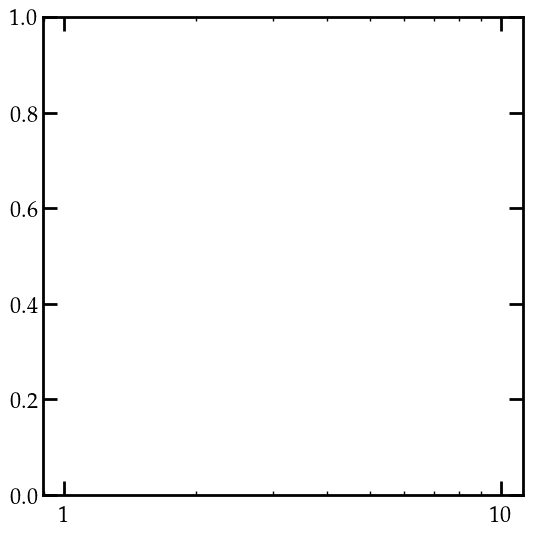

In [14]:
plt.figure()
ax = plt.gca()
# ax.loglog()
plt.xscale('log')
linewidth=1.6

plt.plot(
    eng, 
    eng**2 * lowengphot5e3[395].dNdE/(2*5e3)/norm_fac(rs_list[395],5e3),
    linewidth=linewidth,
    color='red',
    label = r'$E_{inj}$ = 5.00E+03eV'
)
plt.plot(
    eng, 
    eng**2 * lowengphot6e5[395].dNdE/(2*6.19e5)/norm_fac(rs_list[395],6.19e5),
    linewidth=linewidth,
    color='darkgoldenrod',
    label = r'$E_{inj}$ = 6.19E+05eV'
)
plt.plot(
    eng, 
    eng**2 * lowengphot1e8[395].dNdE/(2*1.31e8)/norm_fac(rs_list[395],1.31e8),
    linewidth=linewidth,
    color='green',
    label = r'$E_{inj}$ = 1.31E+08eV'
)
plt.plot(
    eng, 
    eng**2 * lowengphot3e10[395].dNdE/(2*2.77e10)/norm_fac(rs_list[395],2.77e10),
    linewidth=linewidth,
    color='blue',
    label = r'$E_{inj}$ = 2.77E+10eV'
)
plt.plot(
    eng, 
    eng**2 * lowengphot6e12[395].dNdE/(2*5.85e12)/norm_fac(rs_list[395],5.85e12),
    linewidth=linewidth,
    color='purple',
    label = r'$E_{inj}$ = 5.85E+12eV'
)


# plt.plot(eng, eng**2 * distortion_spec5e3.dNdE/(2*5e3))
plt.axis([1e-2,3e3,-2e-1,1])
plt.ylabel(r'$E^2 dN/dE / (2 m_\chi)$')
plt.xlabel('Energy [eV]')
leg = plt.legend()
leg.set_title(r'$\chi\chi \to \gamma\gamma$, s-wave')
plt.title(r'Spectral Distortion Contribution at z $\approx$ 617')
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/PRD_v1/Ref_Response/spec_distortion_comparison_Tracy2015_partI.pdf')
plt.show()

# Attempt 2

Load the data

In [126]:
tmp5e3 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data5e3.p','rb'))
tmp6e5 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data6e5.p','rb'))
tmp1e8 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data1e8.p','rb'))
tmp3e10 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data3e10.p','rb'))
tmp6e12 = pickle.load(open('/Users/gregoryridgway/Desktop/DM/Misc_Data/data6e12.p','rb'))

lowengphot = tmp5e3['lowengphot']
eng = lowengphot.eng
rs_list = lowengphot.rs

Find the total distortion for each of those runs

In [127]:
def get_distortion(specs, mDM):
    specs._grid_vals[:,150:]=0
    for sp in specs:
        sp.dNdE[sp.eng>phys.lya_eng] = 0
    specs.redshift(np.ones_like(rs_list))
    return specs.sum_specs()*phys.nB

In [128]:
distortion_spec_5e3 = get_distortion(tmp5e3['lowengphot'], 5e3)
distortion_spec_6e5 = get_distortion(tmp6e5['lowengphot'], 6.19e5)
distortion_spec_1e8 = get_distortion(tmp1e8['lowengphot'], 1.31e8)
distortion_spec_3e10 = get_distortion(tmp3e10['lowengphot'], 2.77e10)
distortion_spec_6e12 = get_distortion(tmp6e12['lowengphot'], 5.85e12)

Plot the distortion

In [129]:
phys.me/2 * phys.alpha**2 /2

6.8028465041239645

In [130]:
for spec in [distortion_spec_5e3, distortion_spec_6e5, distortion_spec_1e8, distortion_spec_3e10, distortion_spec_6e12]:
    print(spec.toteng()/phys.CMB_eng_density(phys.TCMB(1)))

1.7080551341606353e-11
1.0786712245441405e-09
6.147456249240562e-11
6.274580205332896e-11
6.624841301979906e-11


/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


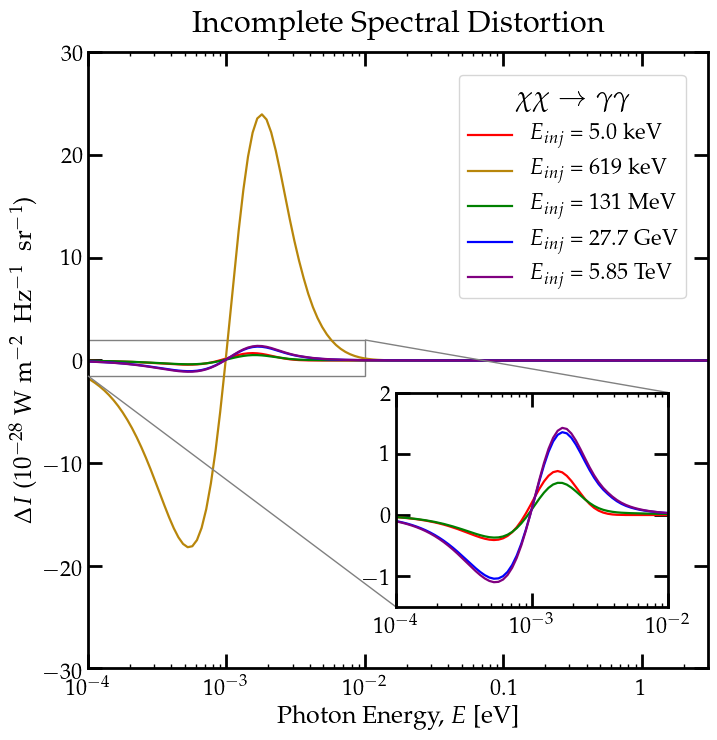

In [106]:
fig_distortion = plt.figure(figsize=(8,8))
ax = plt.gca()
# ax.loglog()
plt.xscale('log')
linewidth=1.6
eng = distortion_spec_5e3.eng#/phys.hbar/(2*np.pi)/1e9
norm=1e28
conversion_fac = phys.ele * 1e4 # conversion from eV/cm^2 to Joule/m^2

fac= norm * conversion_fac * phys.c * phys.hbar * 2*np.pi / (4*np.pi) #*(phys.hbar*(2*np.pi)*1e9)

plt0, = plt.plot(
    eng, 
    fac * eng*distortion_spec_5e3.dNdE ,
    linewidth=linewidth,
    color='red',
    label = r'$E_{inj}$ = $5.0$ keV'
)

plt1, = plt.plot(
    eng, 
    fac * eng*distortion_spec_6e5.dNdE,
    linewidth=linewidth,
    color='darkgoldenrod',
    label = r'$E_{inj}$ = $619$ keV'
)

plt2, = plt.plot(
    eng, 
    fac * eng*distortion_spec_1e8.dNdE,
    linewidth=linewidth,
    color='green',
    label = r'$E_{inj}$ = $131$ MeV'
)

plt3, = plt.plot(
    eng, 
    fac * eng*distortion_spec_3e10.dNdE,
    linewidth=linewidth,
    color='blue',
    label = r'$E_{inj}$ = $27.7$ GeV'
)

plt4, = plt.plot(
    eng, 
    fac * eng*distortion_spec_6e12.dNdE,
    linewidth=linewidth,
    color='purple',
    label = r'$E_{inj}$ = $5.85$ TeV'
)

plt.axis([1e-4,3,-30,30.0])
# plt.ylabel(r'$\Delta I$ ($10^{-'+str(np.floor(10*np.log10(norm))/10)+'}$ W m$^{-2}~$ Hz$^{-1}~$ sr$^{-1}$)')
plt.ylabel(r'$\Delta I$ ($10^{-28}$ W m$^{-2}~$ Hz$^{-1}~$ sr$^{-1}$)')
plt.xlabel(r'Photon Energy, $E$ [eV]')
leg = plt.legend(loc=1, fontsize=16)
leg.set_title(r'$\chi\chi \to \gamma\gamma$')
plt.title(r'Incomplete Spectral Distortion', fontsize=22)


from matplotlib.transforms import blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

transform = blended_transform_factory(fig_distortion.transFigure, ax.transAxes)
axins = inset_axes(ax,  width="40%", height="40%",
                    bbox_to_anchor=(0, 0.1, 0.85, 0.87),
                    bbox_transform=transform, loc=4, borderpad=0)

mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5")

plt.plot(
    eng, 
    fac * eng*distortion_spec_5e3.dNdE ,
    linewidth=linewidth,
    color='red',
    label = r'$E_{inj}$ = $5.0$ keV'
)

plt.plot(
    eng, 
    fac * eng*distortion_spec_1e8.dNdE,
    linewidth=linewidth,
    color='green',
    label = r'$E_{inj}$ = $131$ MeV'
)

plt.plot(
    eng, 
    fac * eng*distortion_spec_3e10.dNdE,
    linewidth=linewidth,
    color='blue',
    label = r'$E_{inj}$ = $27.7$ GeV'
)

plt.plot(
    eng, 
    fac * eng*distortion_spec_6e12.dNdE,
    linewidth=linewidth,
    color='purple',
    label = r'$E_{inj}$ = $5.85$ TeV'
)
plt.xscale('log')
plt.title(r'', fontsize=18, y = 0.95)
# plt.yticks([0.96, 1., 1.04, 1.08, 1.12])
# plt.xticks([1600, 2000, 2400, 2800])
plt.axis([1e-4, 1e-2, -1.5, 2])

# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/PRD_v1/Ref_Response/spec_distortion_example.pdf')
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/PRD_v1/spec_distortion_example.pdf')


plt.show()

In [ ]:
Tm = soln_no_He[:,0]/phys.kB

xe_no_He   = soln_no_He[:,1]
# The other columns with xHeII and xHeIII are negligible.
xe_with_He = soln_with_He[:,1] + soln_with_He[:,2]
#The last column with xHeIII is negligible


fig_He = plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

plt_T_IGM, = plt.plot(rs_vec, Tm, label='IGM Temperature')
# Plot the CMB temperature for comparison, using the function phys.TCMB
plt_T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[plt_T_IGM, plt_T_CMB], loc=4)


plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Temperature [K]')
plt.axis([1, 2e3, 1e-2, 1e4])

ax = plt.subplot(1,2,2)

plt_He,    = plt.plot(rs_vec, xe_with_He, label=r'$x_e$, with He')
plt_no_He, = plt.plot(rs_vec, xe_no_He,   label=r'$x_e$, no He')

plt.legend(handles=[plt_He, plt_no_He], loc=2)

# ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Free Electron Fraction $x_e$')
plt.axis([1, 3e3, 1e-4, 2.7])

from matplotlib.transforms import blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

transform = blended_transform_factory(fig_He.transFigure, ax.transAxes)
axins = inset_axes(ax,  width="22%", height="50%",
                    bbox_to_anchor=(0, 0.1, 0.885, 0.885),
                    bbox_transform=transform, loc=4, borderpad=0)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.plot(rs_vec, xe_with_He)
plt.plot(rs_vec, xe_no_He)
plt.title(r'\bf{Helium Recombination}', fontsize=18, y = 0.95)
plt.yticks([0.96, 1., 1.04, 1.08, 1.12])
plt.xticks([1600, 2000, 2400, 2800])
plt.axis([1.4e3, 3e3, 0.95, 1.13])

# Reproduce Medea

In [22]:
import darkhistory.spec.transferfunction as tf
from scipy.linalg import solve_triangular

In [195]:
rs = 1000
dt = .001/phys.hubble(rs)
n  = phys.nH * rs**3

def sigma_ee(E_in, n_e):
    zeta_e = 7.40e-11 * n_e
    lnLam = np.log(4*E_in/zeta_e)
    f = 0.05
    return 40 * np.pi * (4*np.pi*phys.alpha)**2 * lnLam * (
        phys.hbar * phys.c / E_in)**2 * (.05/f)

In [251]:
xHII = 1e-4
xHI = 1-xHII
xHeI = phys.chi
xHeII = 0
xHeIII = phys.chi - xHeI - xHeII
xe = xHII + xHeII + 2*xHeIII

ne = xe*n
nHI = xHI*n


in_eng  = 10**np.arange(np.log10(1),np.log10(3000),.002)
out_eng = 10**np.arange(np.log10(1),np.log10(3000),.002)

id_mat = np.identity(in_eng.size)

beta_ele = np.sqrt(1 - 1/(1 + in_eng/phys.me)**2)
ve = beta_ele * phys.c

In [256]:
Gamma_ee = ne * sigma_ee(14.0, ne) * ve[ind14]
Gamma_exc = nHI * phys.coll_exc_xsec(14.0, species='HI', method = 'MEDEA', state='2p') * ve[ind14]
Gamma_tot = Gamma_ee + Gamma_exc
print(Gamma_ee/Gamma_tot, Gamma_exc/Gamma_tot)

[0.9946872] [0.0053128]


In [253]:
Gamma_ee = ne * sigma_ee(in_eng, ne) * beta_ele * phys.c
HI_exc_types = ['2s', '2p', '3p', '4p',  '5p', '6p', '7p', '8p', '9p', '10p']
Gamma_exc_HI = np.array([beta_ele * phys.c * nHI * phys.coll_exc_xsec(
    in_eng, species='HI', method = 'MEDEA', state=state) for state in HI_exc_types])

Gamma_tot = Gamma_ee + np.sum(Gamma_exc_HI, axis=0)

In [239]:
#fraction of energy promptly deposited
f_heat = Gamma_ee/Gamma_tot
f_excHI = Gamma_exc_HI/Gamma_tot 

P_heat = f_heat*.05
P_excHI = f_excHI* np.array([[phys.lya_eng], [phys.lya_eng], [12.094], [12.755], 
                             [13.061], [13.228], [13.328], [13.393], 
                             [13.438], [13.470]])/in_eng

#Below 10.2eV, all electrons deposit their energy into heat
P_heat[:Lya_ind] = 1
P_excHI[:,:Lya_ind] = 0

N = id_mat.copy()

In [263]:
N_exc = tf.TransFuncAtRedshift(
    np.squeeze(id_mat[:, np.where(out_eng > phys.lya_eng)]),
    in_eng = in_eng, rs = -1*np.ones_like(out_eng),
    eng = out_eng[out_eng > phys.lya_eng] - phys.lya_eng,
    dlnz = -1, spec_type = 'N'
)

In [209]:
#Find bins that contain thresholds
bnds = spectools.get_bin_bound(in_eng)
Lya_ind = sum(bnds<phys.lya_eng) - 1
ind14 = sum(bnds<14)-1
Ryd_ind = sum(bnds<phys.rydberg) - 1

N = id_mat.copy()

for k,row in enumerate(id_mat[Lya_ind:]):
    i = k+Lya_ind
    N[i]
    

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

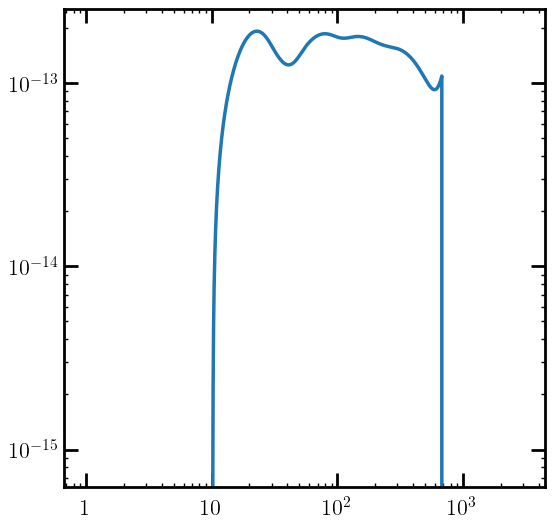

In [77]:
plt.figure()
plt.loglog()
plt.plot(in_eng, Gamma_exc_HI[0])

In [174]:
%autoreload
ind=500
print(np.transpose([in_eng[ind:800],
              phys.coll_exc_xsec(in_eng[ind:800], species='HI', method = 'MEDEA', state='2s')]))

[[1.00000000e+01 0.00000000e+00]
 [1.00461579e+01 0.00000000e+00]
 [1.00925289e+01 0.00000000e+00]
 [1.01391139e+01 0.00000000e+00]
 [1.01859139e+01 0.00000000e+00]
 [1.02329299e+01 4.56949163e-20]
 [1.02801630e+01 1.20618504e-19]
 [1.03276141e+01 1.95409682e-19]
 [1.03752842e+01 2.70064699e-19]
 [1.04231743e+01 3.44579778e-19]
 [1.04712855e+01 4.18951109e-19]
 [1.05196187e+01 4.93174859e-19]
 [1.05681751e+01 5.67247162e-19]
 [1.06169556e+01 6.41164127e-19]
 [1.06659612e+01 7.14921832e-19]
 [1.07151931e+01 7.88516329e-19]
 [1.07646521e+01 8.61943639e-19]
 [1.08143395e+01 9.35199758e-19]
 [1.08642562e+01 1.00828065e-18]
 [1.09144034e+01 1.08118226e-18]
 [1.09647820e+01 1.15390049e-18]
 [1.10153931e+01 1.22643122e-18]
 [1.10662378e+01 1.29877031e-18]
 [1.11173173e+01 1.37091359e-18]
 [1.11686325e+01 1.44285685e-18]
 [1.12201845e+01 1.51459587e-18]
 [1.12719746e+01 1.58612639e-18]
 [1.13240036e+01 1.65744413e-18]
 [1.13762729e+01 1.72854477e-18]
 [1.14287833e+01 1.79942398e-18]
 [1.148153

In [ ]:
def getP(in_eng):
    pvec = in_eng
    prob_heat
    phys.

## Hongwan's Code

In [287]:
from scipy.linalg import solve_triangular

In [277]:
xHII = 1e-4
xHeII = 1e-4
xHeIII = 0
rs=10

xe = xHII + xHeII + 2*xHeIII
beta_ele = np.sqrt(1 - 1/(1 + eleceng/phys.me)**2)

Excitation

In [278]:
# Compute the (normalized) collisional excitation spectra.
id_mat = np.identity(eleceng.size)

# Electron with energy eleceng produces a spectrum with one particle
# of energy eleceng - phys.lya.eng. Similar for helium. 
coll_exc_sec_elec_tf_HI = tf.TransFuncAtRedshift(
    np.squeeze(id_mat[:, np.where(eleceng > phys.lya_eng)]),
    in_eng = eleceng, rs = -1*np.ones_like(eleceng),
    eng = eleceng[eleceng > phys.lya_eng] - phys.lya_eng,
    dlnz = -1, spec_type = 'N'
)

coll_exc_sec_elec_tf_HeI = tf.TransFuncAtRedshift(
    np.squeeze(
        id_mat[:, np.where(eleceng > phys.He_exc_eng['23s'])]
    ),
    in_eng = eleceng, rs = -1*np.ones_like(eleceng),
    eng = (
        eleceng[eleceng > phys.He_exc_eng['23s']]
        - phys.He_exc_eng['23s']
    ),
    dlnz = -1, spec_type = 'N'
)

coll_exc_sec_elec_tf_HeII = tf.TransFuncAtRedshift(
    np.squeeze(id_mat[:, np.where(eleceng > 4*phys.lya_eng)]),
    in_eng = eleceng, rs = -1*np.ones_like(eleceng),
    eng = eleceng[eleceng > 4*phys.lya_eng] - 4*phys.lya_eng,
    dlnz = -1, spec_type = 'N'
)

# Rebin the data so that the spectra stored above now have an abscissa
# of eleceng again (instead of eleceng - phys.lya_eng for HI etc.)
coll_exc_sec_elec_tf_HI.rebin(eleceng)
coll_exc_sec_elec_tf_HeI.rebin(eleceng)
coll_exc_sec_elec_tf_HeII.rebin(eleceng)

# Put them in a tuple.
coll_exc_sec_elec_specs = (
    coll_exc_sec_elec_tf_HI.grid_vals,
    coll_exc_sec_elec_tf_HeI.grid_vals,
    coll_exc_sec_elec_tf_HeII.grid_vals
)

# Collisional excitation rates.
rate_vec_exc_HI = (
    xHI*phys.nH*rs**3 * phys.coll_exc_xsec(eleceng, species='HI', method='old') * beta_ele * phys.c
)

rate_vec_exc_HeI = ( 
    (phys.nHe/phys.nH - xHeII)*phys.nH*rs**3 * phys.coll_exc_xsec(eleceng, species='HeI') * beta_ele * phys.c
)   

rate_vec_exc_HeII = ( 
    xHeII*phys.nH*rs**3 * phys.coll_exc_xsec(eleceng, species='HeII') * beta_ele * phys.c
) 

# Normalized electron spectrum after excitation.
elec_exc_HI_tf = tf.TransFuncAtRedshift(
    rate_vec_exc_HI[:, np.newaxis]*coll_exc_sec_elec_specs[0],
    in_eng = eleceng, rs = rs*np.ones_like(eleceng),
    eng = eleceng, dlnz = -1, spec_type  = 'N'
)

elec_exc_HeI_tf = tf.TransFuncAtRedshift(
    rate_vec_exc_HeI[:, np.newaxis]*coll_exc_sec_elec_specs[1],
    in_eng = eleceng, rs = rs*np.ones_like(eleceng),
    eng = eleceng, dlnz = -1, spec_type  = 'N'
)

elec_exc_HeII_tf = tf.TransFuncAtRedshift(
    rate_vec_exc_HeII[:, np.newaxis]*coll_exc_sec_elec_specs[2],
    in_eng = eleceng, rs = rs*np.ones_like(eleceng),
    eng = eleceng, dlnz = -1, spec_type  = 'N'
)

# Deposited energy for excitation.
deposited_exc_vec = np.zeros_like(eleceng)

# Deposited excitation array.
deposited_exc_eng_arr = (
    phys.lya_eng*np.sum(elec_exc_HI_tf.grid_vals, axis=1)
    + phys.He_exc_eng['23s']*np.sum(elec_exc_HeI_tf.grid_vals, axis=1)
    + 4*phys.lya_eng*np.sum(elec_exc_HeII_tf.grid_vals, axis=1)
)

Ionization

In [283]:
# Collisional ionization secondary electrons
coll_ion_sec_elec_specs = (
    phys.coll_ion_sec_elec_spec(eleceng, eleceng, species='HI'),
    phys.coll_ion_sec_elec_spec(eleceng, eleceng, species='HeI'),
    phys.coll_ion_sec_elec_spec(eleceng, eleceng, species='HeII')
)

# Collisional ionization rates.
rate_vec_ion_HI = (
    (1 - xHII)*phys.nH*rs**3
    * phys.coll_ion_xsec(eleceng, species='HI') * beta_ele * phys.c
)

rate_vec_ion_HeI = (
    (phys.nHe/phys.nH - xHeII)*phys.nH*rs**3
    * phys.coll_ion_xsec(eleceng, species='HeI') * beta_ele * phys.c
)

rate_vec_ion_HeII = (
    xHeII*phys.nH*rs**3
    * phys.coll_ion_xsec(eleceng, species='HeII') * beta_ele * phys.c
)

# Normalized secondary electron spectra after ionization.
elec_spec_ion_HI   = (
    rate_vec_ion_HI[:,np.newaxis]   * coll_ion_sec_elec_specs[0]
)
elec_spec_ion_HeI  = (
    rate_vec_ion_HeI[:,np.newaxis]  * coll_ion_sec_elec_specs[1]
)
elec_spec_ion_HeII = (
    rate_vec_ion_HeII[:,np.newaxis] * coll_ion_sec_elec_specs[2]
)

# Construct TransFuncAtRedshift objects.
elec_ion_HI_tf = tf.TransFuncAtRedshift(
    elec_spec_ion_HI, in_eng = eleceng, rs = rs*np.ones_like(eleceng),
    eng = eleceng, dlnz = -1, spec_type = 'N'
)
elec_ion_HeI_tf = tf.TransFuncAtRedshift(
    elec_spec_ion_HeI, in_eng = eleceng, rs = rs*np.ones_like(eleceng),
    eng = eleceng, dlnz = -1, spec_type = 'N'
)
elec_ion_HeII_tf = tf.TransFuncAtRedshift(
    elec_spec_ion_HeII, in_eng = eleceng, rs = rs*np.ones_like(eleceng),
    eng = eleceng, dlnz = -1, spec_type = 'N'
)

# Deposited energy for ionization.
deposited_ion_vec = np.zeros_like(eleceng)

# Deposited ionization array.
deposited_ion_eng_arr = (
    phys.rydberg*np.sum(elec_ion_HI_tf.grid_vals, axis=1)/2
    + phys.He_ion_eng*np.sum(elec_ion_HeI_tf.grid_vals, axis=1)/2
    + 4*phys.rydberg*np.sum(elec_ion_HeII_tf.grid_vals, axis=1)/2
)

Heat

In [284]:
dE_heat_dt = phys.elec_heating_engloss_rate(eleceng, xHII, rs)

#pre-allocate
deposited_heat_vec = np.zeros_like(eleceng)
elec_heat_spec_grid = np.identity(eleceng.size)

## 1/DelE (dE/dt)

#edge case, upper left corner
elec_heat_spec_grid[0,0] -= dE_heat_dt[0]/eleceng[0]

#rest of the matrix
elec_heat_spec_grid[1:, 1:] += np.diag(
    dE_heat_dt[1:]/(eleceng[:-1] - eleceng[1:])
)
elec_heat_spec_grid[1:, :-1] -= np.diag(
    dE_heat_dt[1:]/(eleceng[:-1] - eleceng[1:])
)

# Deposited heating array.
deposited_heat_eng_arr = dE_heat_dt

In [285]:
# Secondary scattered electron spectrum.
sec_elec_spec_N_arr = (
#     elec_ICS_tf.grid_vals
    elec_exc_HI_tf.grid_vals
    + elec_exc_HeI_tf.grid_vals
    + elec_exc_HeII_tf.grid_vals
    + elec_ion_HI_tf.grid_vals
    + elec_ion_HeI_tf.grid_vals
    + elec_ion_HeII_tf.grid_vals
    + elec_heat_spec_grid
)

# Remove self-scattering, re-normalize. 
np.fill_diagonal(sec_elec_spec_N_arr, 0)

toteng_no_self_scatter_arr = (
    np.dot(sec_elec_spec_N_arr, eleceng)
#     + np.dot(sec_phot_spec_N_arr, photeng)
#     - continuum_engloss_arr
#     + deposited_ICS_eng_arr
    + deposited_exc_eng_arr
    + deposited_ion_eng_arr
    + deposited_heat_eng_arr
)

fac_arr = eleceng/toteng_no_self_scatter_arr

sec_elec_spec_N_arr *= fac_arr[:, np.newaxis]

In [288]:
deposited_exc_vec  = solve_triangular(
    np.identity(eleceng.size) - sec_elec_spec_N_arr,
    deposited_exc_eng_arr, lower=True, check_finite=False
)
deposited_ion_vec  = solve_triangular(
    np.identity(eleceng.size) - sec_elec_spec_N_arr,
    deposited_ion_eng_arr, lower=True, check_finite=False
)
deposited_heat_vec = solve_triangular(
    np.identity(eleceng.size) - sec_elec_spec_N_arr,
    deposited_heat_eng_arr, lower=True, check_finite=False
)

In [294]:
eleceng[24]

2.34218203072669

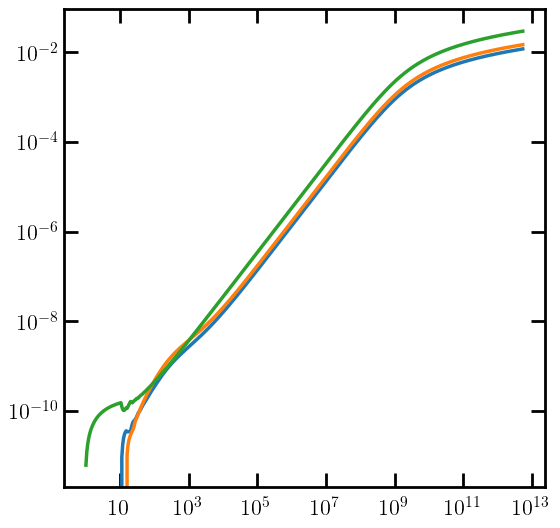

In [290]:
plt.figure()
plt.loglog()
plt.plot(eleceng, deposited_exc_vec)
plt.plot(eleceng, deposited_ion_vec)
plt.plot(eleceng, deposited_heat_vec)

In [ ]:
in_eng = 10**np.arange(1,3000,.1)
out_eng = 10**np.arange(1,3000,.1)
prompt = np.zeros_like(in_eng)
sec = np.zeros((in_eng.size, out_eng.size))

heat_mask = eng<phys.lya_eng
Lya_mask  = (phys.lya_eng<eng) && (eng < phys.rydberg)
ryd_mask  = (phys.rydberg<eng) #&& (eng < phys.rydberg)

# Thoughtless usage of Hongwan's Code

In [59]:
import darkhistory.electrons.elec_cooling as elec_cooling
from config import load_data
from   darkhistory.spec.spectools import EnglossRebinData
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf

In [51]:
# Load data.
binning = load_data('binning')
photeng = binning['phot']
eleceng = binning['elec']

dep_tf_data = load_data('dep_tf')

ics_tf_data = load_data('ics_tf')

ics_thomson_ref_tf  = ics_tf_data['thomson']
ics_rel_ref_tf      = ics_tf_data['rel']
engloss_ref_tf      = ics_tf_data['engloss']

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [74]:
def get_elec_cooling_data(eleceng, photeng):
    # Compute the (normalized) collisional ionization spectra.
    coll_ion_sec_elec_specs = (
        phys.coll_ion_sec_elec_spec(eleceng, eleceng, species='HI', method='MEDEA'),
        phys.coll_ion_sec_elec_spec(eleceng, eleceng, species='HeI'),
        phys.coll_ion_sec_elec_spec(eleceng, eleceng, species='HeII')
    )
    # Compute the (normalized) collisional excitation spectra.
    id_mat = np.identity(eleceng.size)

    # Electron with energy eleceng produces a spectrum with one particle
    # of energy eleceng - phys.lya.eng. Similar for helium. 
    coll_exc_sec_elec_tf_HI = tf.TransFuncAtRedshift(
        np.squeeze(id_mat[:, np.where(eleceng > phys.lya_eng)]),
        in_eng = eleceng, rs = -1*np.ones_like(eleceng),
        eng = eleceng[eleceng > phys.lya_eng] - phys.lya_eng,
        dlnz = -1, spec_type = 'N'
    )

    coll_exc_sec_elec_tf_HeI = tf.TransFuncAtRedshift(
        np.squeeze(
            id_mat[:, np.where(eleceng > phys.He_exc_eng['23s'])]
        ),
        in_eng = eleceng, rs = -1*np.ones_like(eleceng),
        eng = (
            eleceng[eleceng > phys.He_exc_eng['23s']]
            - phys.He_exc_eng['23s']
        ),
        dlnz = -1, spec_type = 'N'
    )

    coll_exc_sec_elec_tf_HeII = tf.TransFuncAtRedshift(
        np.squeeze(id_mat[:, np.where(eleceng > 4*phys.lya_eng)]),
        in_eng = eleceng, rs = -1*np.ones_like(eleceng),
        eng = eleceng[eleceng > 4*phys.lya_eng] - 4*phys.lya_eng,
        dlnz = -1, spec_type = 'N'
    )

    # Rebin the data so that the spectra stored above now have an abscissa
    # of eleceng again (instead of eleceng - phys.lya_eng for HI etc.)
    coll_exc_sec_elec_tf_HI.rebin(eleceng)
    coll_exc_sec_elec_tf_HeI.rebin(eleceng)
    coll_exc_sec_elec_tf_HeII.rebin(eleceng)

    # Put them in a tuple.
    coll_exc_sec_elec_specs = (
        coll_exc_sec_elec_tf_HI.grid_vals,
        coll_exc_sec_elec_tf_HeI.grid_vals,
        coll_exc_sec_elec_tf_HeII.grid_vals
    )

    # Store the ICS rebinning data for speed. Contains information
    # that makes converting an energy loss spectrum to a scattered
    # electron spectrum fast. 
    ics_engloss_data = EnglossRebinData(eleceng, photeng, eleceng)

    return (
        coll_ion_sec_elec_specs, coll_exc_sec_elec_specs, ics_engloss_data
    )

In [75]:
(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs,
    ics_engloss_data
) = get_elec_cooling_data(eleceng, photeng)

In [98]:
%autoreload
xHII=1.0
(
    ics_sec_phot_tf, elec_processes_lowengelec_tf,
    deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
    continuum_loss, deposited_ICS_arr
) = get_elec_cooling_tf(
        eleceng, photeng, 1,
        xHII, xHeII=0,
        raw_thomson_tf=ics_thomson_ref_tf,
        raw_rel_tf=ics_rel_ref_tf,
        raw_engloss_tf=engloss_ref_tf,
        coll_ion_sec_elec_specs=coll_ion_sec_elec_specs,
        coll_exc_sec_elec_specs=coll_exc_sec_elec_specs,
        ics_engloss_data=ics_engloss_data
    )

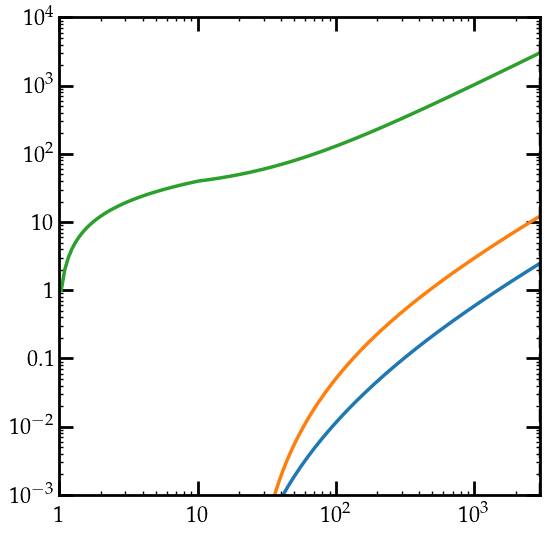

In [99]:
plt.figure()
plt.loglog()
plt.axis([1,3e3,1e-3,1e4])
plt.plot(eleceng, deposited_exc_arr)
plt.plot(eleceng, deposited_ion_arr)
plt.plot(eleceng, deposited_heat_arr)
plt.axvline(3e3,color='k',linestyle='--')